# < Object Detection으로 자율주행 보조 시스템 만들기 >

-목차-

□ Step1 KITTI 데이터셋 준비    
□ Step2 Keras-RetinaNet 모델 학습   
□ Step3 Keras-RetinaNet 모델 학습 결과 시각화   
□ Step4 자율주행 보조 시스템 만들기    
□ 정리 및 회고

### ■ Step1 KITTI 데이터셋 준비

**1-1 필요한 라이브러리 import**

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

**1-2 KITTI 데이터셋 다운로드**

In [2]:
import urllib3
urllib3.disable_warnings()

data_dir = os.path.join(os.getenv("HOME"), "aiffel/object_detection/data")

(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=data_dir,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

**1-3 데이터셋 샘플 확인**

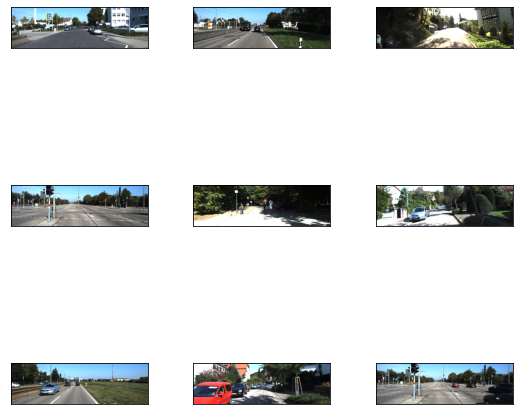

In [3]:
_ = tfds.show_examples(ds_train, ds_info)

**1-4 데이터셋 정보 확인**

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

**1-5 데이터 직접 확인**

- 데이터를 직접 확인하면, image, label 등의 정보를 보며 데이터를 이해할 수 있음

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(7,), dtype=float32, numpy=array([ 1.73, -1.13,  1.68, -1.21,  1.88,  1.63, -1.56], dtype=float32)>, 'bbox': <tf.Tensor: shape=(7, 4), dtype=float32, numpy=
array([[0.36928   , 0.35852656, 0.53210664, 0.4222625 ],
       [0.44090667, 0.19015297, 0.51610667, 0.23458132],
       [0.44922668, 0.4192512 , 0.52066666, 0.4475926 ],
       [0.47016   , 0.2821739 , 0.52242666, 0.3091546 ],
       [0.47656   , 0.30069244, 0.5250933 , 0.32636875],
       [0.47306666, 0.44150564, 0.53024   , 0.45994365],
       [0.43090665, 0.47220612, 0.53      , 0.50223833]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(7, 3), dtype=float32, numpy=
array([[1.66, 1.67, 4.49],
       [1.56, 1.72, 3.09],
       [1.46, 1.59, 4.12],
       [1.57, 1.57, 3.32],
       [1.57, 1.2 , 5.24],
       [1.72, 1.66, 4.32],
       [1.62, 1.63, 4.5 ]], dtype=float32)>, 'location': <tf.Tensor: shape=(7, 3), dtype=float

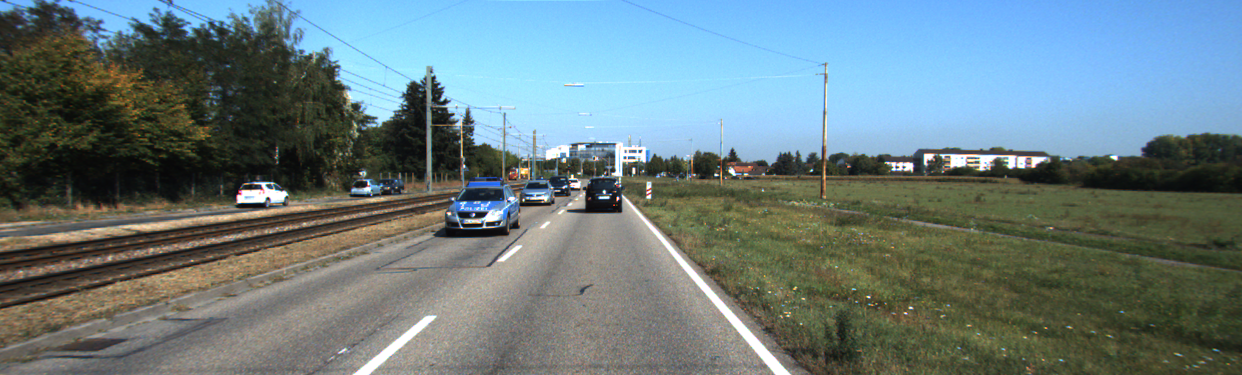

In [5]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
img

**1-6 바운딩 박스 그리기 함수 정의 및 적용**

width: 1242  height: 375
(7, 4)
[445.28998 236.51999 524.45    175.46   ]
[236.17 209.66 291.35 181.46]
[520.71 206.54 555.91 179.75]
[350.46 198.69 383.97 179.09]
[373.46002 196.29001 405.34998 178.09001]
[548.35 197.6  571.25 176.16]
[586.48    213.41    623.78    176.25002]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7F8CDDD45C10>


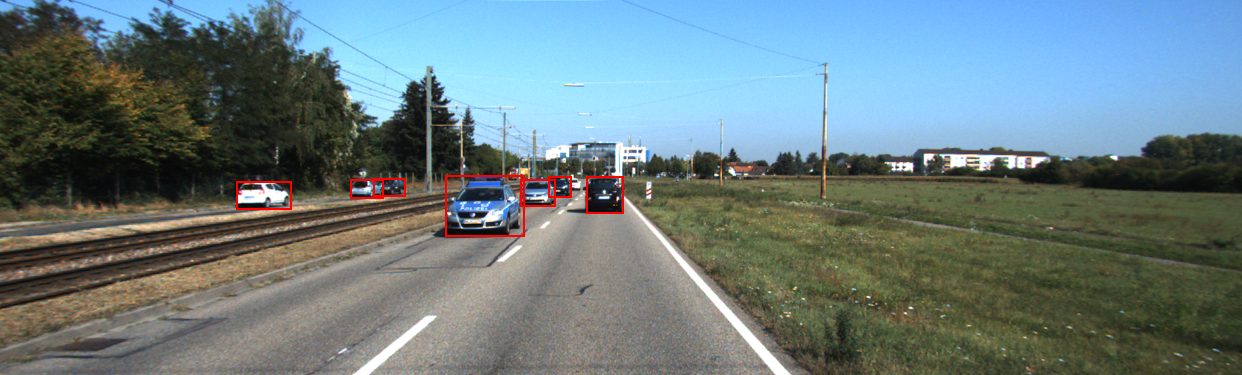

In [6]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print('width:', width, ' height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

### ■ Step2 Keras-RetinaNet 모델 학습

**2-1 데이터셋 포맷을 CSV로 변경하는 함수 정의 및 적용**

In [10]:
import os
data_dir = os.getenv('HOME') + '/aiffel/object_detection/data'
img_dir = data_dir + '/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'
test_csv_path = data_dir + '/kitti_test.csv'

# KITTI 데이터셋 ds_train을 파싱해서 dataframe으로 변환하는 parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir, total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 저는 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        # 코드 구현
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)
        
        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size
        
        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height
        
        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
    
    return df

In [8]:
# train 데이터셋 csv 파일 만들기
df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',', index=False, header=False)

100%|██████████| 6347/6347 [25:05<00:00,  4.22it/s]


In [11]:
# test 데이터셋 csv 파일 만들기
df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',', index=False, header=False)

100%|██████████| 711/711 [02:54<00:00,  4.08it/s]


**2-2 클래스 맵핑 함수 정의 및 적용**

In [12]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")
    print('Done')
            

save_class_format(class_txt_path)

Done


In [21]:
!pip install progressbar2

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [23]:
!pip install keras-resnet

  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20486 sha256=6485c22520040d01771bc3a085ec6187ab3935d9cb0f5cf6e0c9456cd4be7b1b
  Stored in directory: /aiffel/.cache/pip/wheels/bd/ef/06/5d65f696360436c3a423020c4b7fd8c558c09ef264a0e6c575
Successfully built keras-resnet
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


**2-3 RetinaNet 학습**

In [24]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 10 --steps 195 csv data/kitti_train.csv data/classes.txt
print("Done")

2021-12-30 12:00:36.626065: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-12-30 12:00:38.696250: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-30 12:00:38.697232: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-30 12:00:38.722452: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-30 12:00:38.723240: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8755GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-12-30 12:00:38.723281: I tensorflow/stream_executor/platform/default/dso_lo

res2c_branch2c (Conv2D)         (None, None, None, 2 16384       res2c_branch2b_relu[0][0]        
__________________________________________________________________________________________________
bn2c_branch2c (BatchNormalizati (None, None, None, 2 1024        res2c_branch2c[0][0]             
__________________________________________________________________________________________________
res2c (Add)                     (None, None, None, 2 0           bn2c_branch2c[0][0]              
                                                                 res2b_relu[0][0]                 
__________________________________________________________________________________________________
res2c_relu (Activation)         (None, None, None, 2 0           res2c[0][0]                      
__________________________________________________________________________________________________
res3a_branch2a (Conv2D)         (None, None, None, 1 32768       res2c_relu[0][0]                 
__________

2021-12-30 12:00:44.614811: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-30 12:00:44.631569: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300000000 Hz
Epoch 1/10
2021-12-30 12:00:54.566672: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2021-12-30 12:00:56.145787: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2021-12-30 12:00:56.177570: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-12-30 12:00:58.088804: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-12-30 12:00:58.314770: I tensor

**2-4 학습된 모델을 케라스 모델로 변환**

In [25]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_10.h5 snapshots/resnet50_csv_10_infer.h5
print("Done")

2021-12-30 12:52:31.417934: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-12-30 12:52:33.228029: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-30 12:52:33.228935: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-30 12:52:33.254056: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-30 12:52:33.254848: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8755GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-12-30 12:52:33.254889: I tensorflow/stream_executor/platform/default/dso_lo

### ■ Step3 Keras-RetinaNet 모델 학습 결과 시각화

**3-1 시각화 함수 정의**

In [28]:
!pip install keras_retinanet

     |████████████████████████████████| 71 kB 11.5 MB/s eta 0:00:01
  Using cached Cython-0.29.26-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp37-cp37m-linux_x86_64.whl size=166394 sha256=519cd99e94e15b00a74fe50a78b7281806dd4f8b10b8e1352067514c11d602d1
  Stored in directory: /aiffel/.cache/pip/wheels/55/a1/41/f2dbc08b26549fe00041b9bc25c299f262b0311ad68cc52522
Successfully built keras-retinanet
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [29]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

dir_path = os.getenv('HOME') + '/aiffel/object_detection/'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_10_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Physical devices cannot be modified after being initialized
1 Physical GPUs, 1 Logical GPUs


**3-2 결과 확인 함수 정의**

[191.42722 133.47813 361.4941  239.426  ]
[594.4345  176.22366 626.0095  203.56615]
[374.99066 183.43283 418.88544 210.86218]
[530.91724 161.94414 565.84705 190.69974]


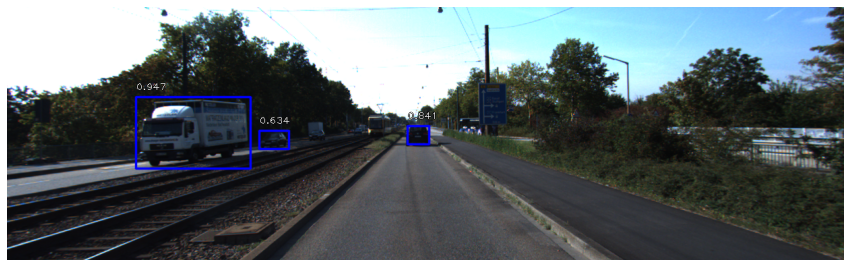

([array([191.42722, 133.47813, 361.4941 , 239.426  ], dtype=float32),
  array([594.4345 , 176.22366, 626.0095 , 203.56615], dtype=float32),
  array([374.99066, 183.43283, 418.88544, 210.86218], dtype=float32),
  array([530.91724, 161.94414, 565.84705, 190.69974], dtype=float32)],
 [0, 0, 0, 0])

In [36]:
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path, visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    box_arr = []
    label_arr = []
    
    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            
            box_arr.append(box)
            label_arr.append(label)
            print(box)
            
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()
    
    return box_arr, label_arr

inference_on_image(model, img_path)

**3-3 다른 이미지 확인**

[769.6398  148.85147 844.76044 308.68225]
[730.3786  144.40344 869.1392  333.73672]


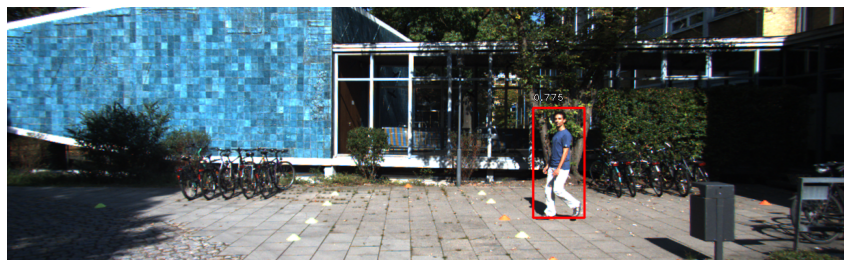

In [31]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
inference_on_image(model, img_path)

### ■ Step4 자율주행 보조 시스템 만들기

**4-1 조건에 따라 Stop/Go 하는 자율주행 보조 시스템 함수 정의 및 적용**

- 조건1 : 사람이 한 명 이상 있는 경우

- 조건2 : 차량의 크기(width or height)가 300px이상인 경우

[769.6398  148.85147 844.76044 308.68225]
[730.3786  144.40344 869.1392  333.73672]


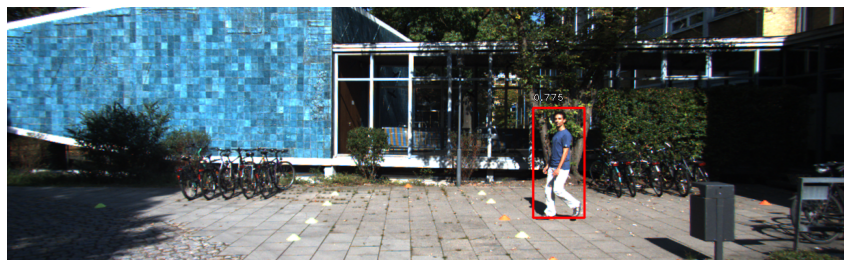

Stop


In [37]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'

def self_drive_assist(img_path, size_limit=300):
    box_arr, label_arr = inference_on_image(model, img_path)
    for box, label in zip(box_arr, label_arr):
        w = abs(box[0] - box[2])
        h = abs(box[1] - box[3])
        
        if label == 1 or w >= size_limit or h >= size_limit:
            return 'Stop'
        else:
            return 'Go'
        
print(self_drive_assist(img_path))

**4-2 자율주행 보조 시스템 평가하기**

[769.6398  148.85147 844.76044 308.68225]
[730.3786  144.40344 869.1392  333.73672]


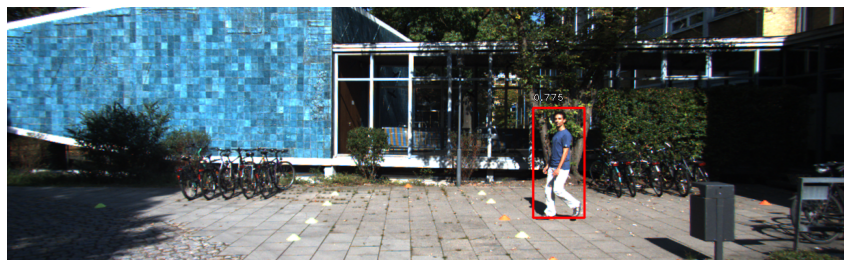

test_set/stop_1.png
prediction: Stop, answer: Stop

[414.50464 162.65611 498.30334 321.58493]
[412.38596 160.44647 499.09506 326.8317 ]


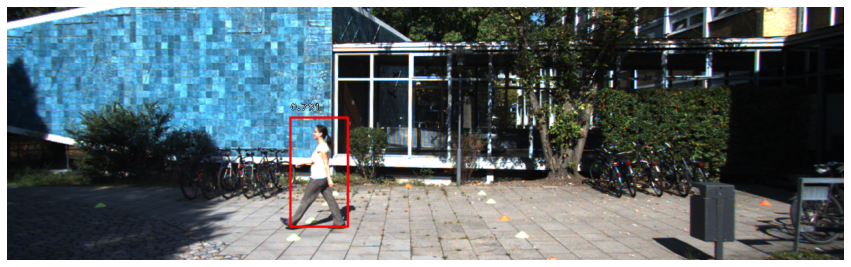

test_set/stop_2.png
prediction: Stop, answer: Stop

[  0.      198.21161 308.1203  369.12827]
[747.9637  160.53813 880.6198  217.87166]
[1000.7686   144.5569  1043.0363   227.02573]


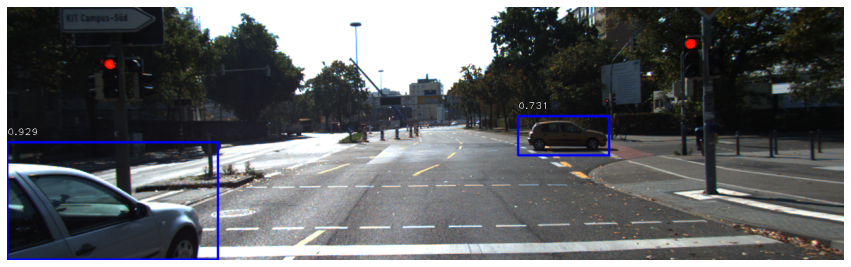

test_set/stop_3.png
prediction: Stop, answer: Stop

[659.24963 139.35165 738.97186 225.9388 ]
[439.38953 159.31494 553.50604 212.77357]
[ 703.56226   97.88661 1095.6727   351.6201 ]
[ 74.892815 154.55334  369.29108  306.59036 ]
[359.79224 172.36055 488.63895 223.34311]
[391.03757 161.93452 533.2967  223.51135]
[674.34717 136.86952 801.4076  247.3196 ]


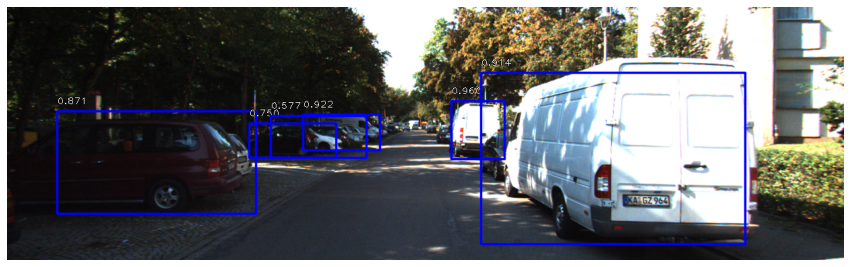

test_set/stop_4.png
prediction: Go, answer: Stop

[ 871.86896  177.08142 1218.5991   365.74744]
[697.70526 140.83485 773.2539  217.8931 ]
[733.828   159.81984 860.1929  251.51071]
[567.15344 180.70242 617.3235  215.6835 ]
[714.8012  147.98433 825.8682  231.83057]
[693.1735  152.97986 751.30597 205.30116]


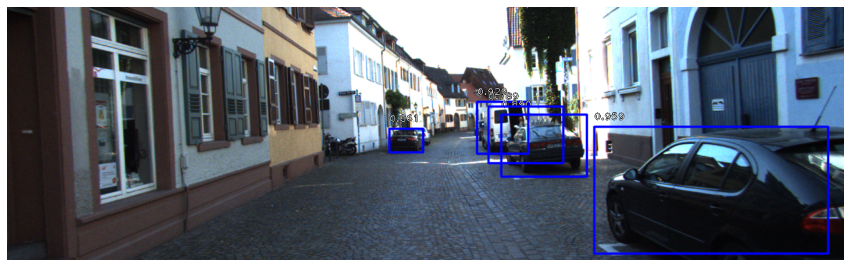

test_set/stop_5.png
prediction: Stop, answer: Stop

[191.42722 133.47813 361.4941  239.426  ]
[594.4345  176.22366 626.0095  203.56615]
[374.99066 183.43283 418.88544 210.86218]
[530.91724 161.94414 565.84705 190.69974]


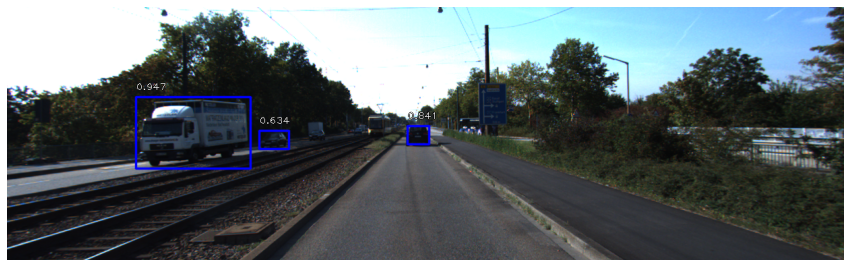

test_set/go_1.png
prediction: Go, answer: Go

[629.0102  179.0856  669.85583 213.5876 ]
[518.3561  177.68434 569.7761  216.18315]
[532.4799  177.10292 580.35376 206.97473]


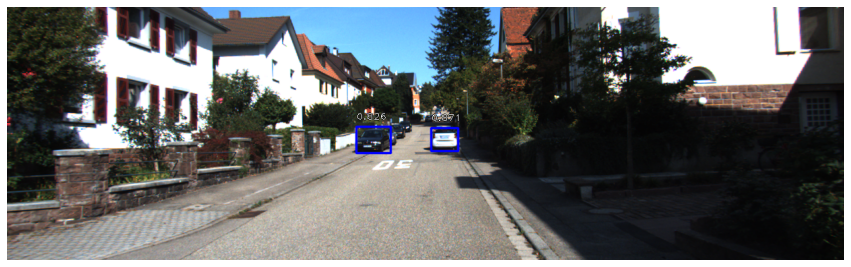

test_set/go_2.png
prediction: Go, answer: Go

[817.7924  148.32297 885.74023 180.27432]


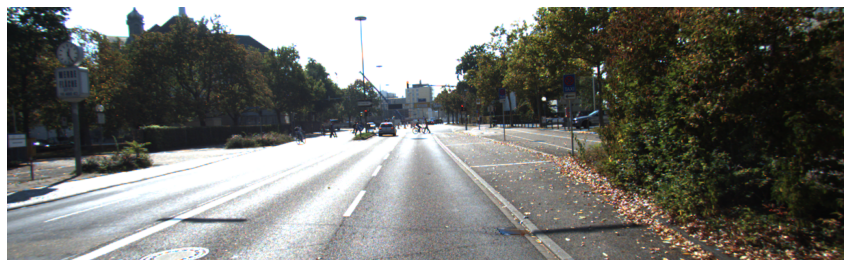

test_set/go_3.png
prediction: Go, answer: Go

[698.3542  168.17302 800.6927  258.29022]
[694.9026  163.2377  805.4354  261.52164]


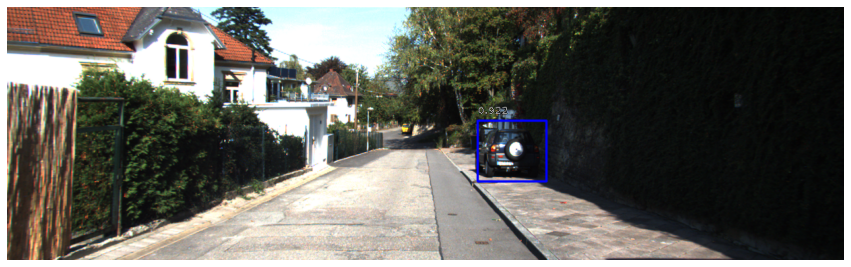

test_set/go_4.png
prediction: Go, answer: Go

[  0.      190.40369 223.65167 307.3614 ]
[149.68382 179.8997  334.82104 262.72015]
[ 74.54758 188.41669 308.97537 274.99014]
[318.96396 177.5794  436.86917 226.08392]
[434.81934 177.04762 498.42676 211.32788]
[457.92154 179.38036 508.92075 204.57108]


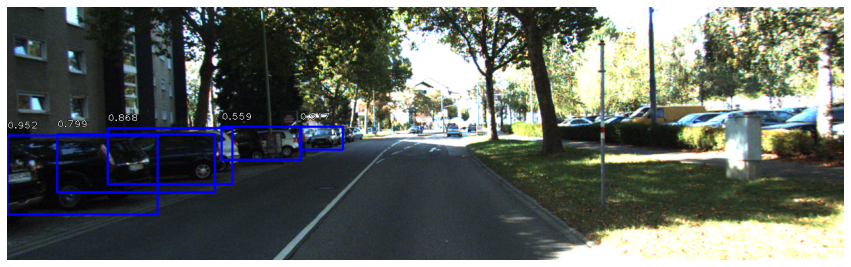

test_set/go_5.png
prediction: Go, answer: Go

90점입니다.


In [39]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        print(image_file)        
        print(f'prediction: {pred}, answer: {answer}\n')
            
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

### ■ 정리 및 회고

**1. KITTI 데이터셋에 대한 분석이 체계적으로 진행되었다.**

- KITTI 데이터셋 구조와 내용을 파악하고 이를 토대로 필요한 데이터셋 가공(csv 파일로 변환)을 정상 진행하였다.


**2. RetinaNet 학습이 정상적으로 진행되어 object detection 결과의 시각화까지 진행되었다.**

- 바운딩박스가 정확히 표시된 시각화된 이미지를 생성하였다.


**3. 자율주행 Object Detection 테스트시스템 적용결과 만족스러운 정확도 성능을 달성하였다.**

- 테스트 수행결과 90점을 맞어 90% 이상의 정확도를 보였다.

**4. 이번 프로젝트를 통해 Object Detection에 대해 자세히 알게 되어 좋았고, 간단하게 나마 자율주행 시스템에 어떻게 적용될 수 있을지 경험해보게 되어 흥미로웠다.**